In [2]:
import os
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from itertools import combinations

In [3]:
#phase_dir = '../phased_spark'
#assembly = '38'

#sample_to_age = dict()
#with open('../phenotypes/basic_medical_screening.csv', 'r') as f:
#    next(f) # skip header
#    for line in f:
#        pieces = line.strip().split(',')
#        sample_to_age[pieces[0]] = int(pieces[8])
        

#phase_dir = '../phased_ihart'
#assembly = '37'

phase_dirs = ['../phased_ssc.hg38', '../phased_mssng_quads', '../phased_ihart.ms2_quads']
#phase_dirs = ['../phased_ihart.ms2_quads']
assembly = '38'

In [4]:
# From GRCh37.p13 https://www.ncbi.nlm.nih.gov/grc/human/data?asm=GRCh37.p13
chrom_lengths37 = {
	'1': 249250621,
	'2': 243199373,
	'3': 198022430,
	'4': 191154276,
	'5': 180915260,
	'6': 171115067,
	'7': 159138663,
	'8': 146364022,
	'9': 141213431,
	'10': 135534747,
	'11': 135006516,
	'12': 133851895,
	'13': 115169878,
	'14': 107349540,
	'15': 102531392,
	'16': 90354753,
	'17': 81195210,
	'18': 78077248,
	'19': 59128983,
	'20': 63025520,
	'21': 48129895,
	'22': 51304566,
#	'X': 155270560,
#	'Y': 59373566
}

# From GRCh38.p13 https://www.ncbi.nlm.nih.gov/grc/human/data?asm=GRCh38.p13
chrom_lengths38 = {
	'1': 248956422,
	'2': 242193529,
	'3': 198295559,
	'4': 190214555,
	'5': 181538259,
	'6': 170805979,
	'7': 159345973,
	'8': 145138636,
	'9': 138394717,
	'10': 133797422,
	'11': 135086622,
	'12': 133275309,
	'13': 114364328,
	'14': 107043718,
	'15': 101991189,
	'16': 90338345,
	'17': 83257441,
	'18': 80373285,
	'19': 58617616,
	'20': 64444167,
	'21': 46709983,
	'22': 50818468,
#	'X': 156040895,
#	'Y': 57227415
}

if assembly == '38':
    chrom_lengths = chrom_lengths38
else:
    chrom_lengths = chrom_lengths37

In [5]:
cyto = []
with open('../data/cytoBand%s.txt' % assembly, 'r') as f:
    next(f)
    for line in f:
        pieces = line.strip().split('\t')
        cyto.append((pieces[0], int(pieces[1]), int(pieces[2]), pieces[3], pieces[4]))



In [6]:
child_to_crossovers = defaultdict(list)
already_included = set()
for phase_dir in phase_dirs:
    print(phase_dir)
    for file in sorted(os.listdir(phase_dir)):
        if file.endswith('.crossovers.json'):
            with open('%s/%s' % (phase_dir, file), 'r') as f:
                cos = json.load(f)
                if len(cos)>=250:
                    print('Are they related?', cos[0]['child'][0], cos[0]['child'][1], file)
                elif cos[0]['child'][0] in already_included or cos[0]['child'][1] in already_included:
                    print('Child(ren) already included in analysis', cos[0]['child'][0], cos[0]['child'][1], file)
                else:
                    for co in cos:
                        child_to_crossovers[tuple(co['child'])].append(co)
                    already_included.add(co['child'][0])
                    already_included.add(co['child'][1])
    print(len(child_to_crossovers))
            
print(len(child_to_crossovers))

../phased_ssc.hg38
Are they related? SSC06079 SSC06086 12970.crossovers.json
Are they related? SSC10135 SSC10120 13949.crossovers.json
Are they related? SSC10090 SSC10085 13976.crossovers.json
Are they related? SSC11682 SSC11693 14357.crossovers.json
Are they related? SSC12169 SSC12150 14655.crossovers.json
1921
../phased_mssng_quads
Child(ren) already included in analysis 1-0153-003A 1-0153-005A 1-0153.1-0153-003A.1-0153-005A.crossovers.json
Child(ren) already included in analysis 1-0153-004A 1-0153-005A 1-0153.1-0153-004A.1-0153-005A.crossovers.json
Child(ren) already included in analysis 1-0263-003B 1-0263-004B 1-0263.1-0263-003B.1-0263-004B.crossovers.json
Child(ren) already included in analysis 1-0278-005A 1-0278-003 1-0278.1-0278-003.1-0278-005A.crossovers.json
Child(ren) already included in analysis 1-0278-003A 1-0278-004A 1-0278.1-0278-003A.1-0278-004A.crossovers.json
Child(ren) already included in analysis 1-0278-005A 1-0278-004A 1-0278.1-0278-004A.1-0278-005A.crossovers.json


Child(ren) already included in analysis 7-0423-005 7-0423-003 7-0423.7-0423-003.7-0423-005.crossovers.json
Child(ren) already included in analysis 7-0423-003 7-0423-006 7-0423.7-0423-003.7-0423-006.crossovers.json
Child(ren) already included in analysis 7-0423-005 7-0423-004 7-0423.7-0423-004.7-0423-005.crossovers.json
Child(ren) already included in analysis 7-0423-004 7-0423-006 7-0423.7-0423-004.7-0423-006.crossovers.json
Child(ren) already included in analysis AU003406 AU003403 AU0034.AU003403.AU003406.crossovers.json
Child(ren) already included in analysis AU003405 AU003406 AU0034.AU003405.AU003406.crossovers.json
Child(ren) already included in analysis AU024606 AU024608 AU0246.AU024606.AU024608.crossovers.json
Child(ren) already included in analysis AU024608 AU024607 AU0246.AU024607.AU024608.crossovers.json
Child(ren) already included in analysis AU046707 AU046703 AU0467.AU046703.AU046707.crossovers.json
Child(ren) already included in analysis AU046708 AU046703 AU0467.AU046703.AU0

Child(ren) already included in analysis REACH000417 REACH000418 F0206.REACH000417.REACH000418.crossovers.json
Child(ren) already included in analysis REACH000427 REACH000423 F0208.REACH000423.REACH000427.crossovers.json
Child(ren) already included in analysis REACH000423 REACH000428 F0208.REACH000423.REACH000428.crossovers.json
Child(ren) already included in analysis REACH000426 REACH000427 F0208.REACH000426.REACH000427.crossovers.json
Child(ren) already included in analysis REACH000426 REACH000428 F0208.REACH000426.REACH000428.crossovers.json
Child(ren) already included in analysis REACH000471 REACH000475 F0219.REACH000471.REACH000475.crossovers.json
Child(ren) already included in analysis REACH000475 REACH000474 F0219.REACH000474.REACH000475.crossovers.json
Child(ren) already included in analysis REACH000483 REACH000479 F0221.REACH000479.REACH000483.crossovers.json
Child(ren) already included in analysis REACH000482 REACH000483 F0221.REACH000482.REACH000483.crossovers.json
Child(ren)

Child(ren) already included in analysis MSSNG00421-004 MSSNG00421-005 MSSNG00421-003.MSSNG00421-004.MSSNG00421-005.crossovers.json
Child(ren) already included in analysis MSSNG00421-004 MSSNG00421-006 MSSNG00421-003.MSSNG00421-004.MSSNG00421-006.crossovers.json
Child(ren) already included in analysis MSSNG00421-004 MSSNG00421-007 MSSNG00421-003.MSSNG00421-004.MSSNG00421-007.crossovers.json
Child(ren) already included in analysis MSSNG00421-008 MSSNG00421-004 MSSNG00421-003.MSSNG00421-004.MSSNG00421-008.crossovers.json
Child(ren) already included in analysis MSSNG00421-009 MSSNG00421-004 MSSNG00421-003.MSSNG00421-004.MSSNG00421-009.crossovers.json
Child(ren) already included in analysis MSSNG00421-005 MSSNG00421-007 MSSNG00421-003.MSSNG00421-005.MSSNG00421-007.crossovers.json
Child(ren) already included in analysis MSSNG00421-005 MSSNG00421-008 MSSNG00421-003.MSSNG00421-005.MSSNG00421-008.crossovers.json
Child(ren) already included in analysis MSSNG00421-005 MSSNG00421-009 MSSNG00421-00

Child(ren) already included in analysis AU021005 AU021003 AU0210.AU021003.AU021005.crossovers.json
Child(ren) already included in analysis AU021004 AU021005 AU0210.AU021004.AU021005.crossovers.json
Child(ren) already included in analysis AU021503 AU021508 AU0215.AU021503.AU021508.crossovers.json
Child(ren) already included in analysis AU021504 AU021508 AU0215.AU021504.AU021508.crossovers.json
Child(ren) already included in analysis AU0226303 AU0226301 AU0226.AU0226301.AU0226303.crossovers.json
Child(ren) already included in analysis AU0226302 AU0226303 AU0226.AU0226302.AU0226303.crossovers.json
Child(ren) already included in analysis AU022705 AU022703 AU0227.AU022703.AU022705.crossovers.json
Child(ren) already included in analysis AU023503 AU023505 AU0235.AU023503.AU023505.crossovers.json
Child(ren) already included in analysis AU023503 AU023506 AU0235.AU023503.AU023506.crossovers.json
Child(ren) already included in analysis AU023505 AU023504 AU0235.AU023504.AU023505.crossovers.json
Ch

Child(ren) already included in analysis AU066005 AU066004 AU0660.AU066004.AU066005.crossovers.json
Child(ren) already included in analysis AU066503 AU066505 AU0665.AU066503.AU066505.crossovers.json
Child(ren) already included in analysis AU066504 AU066505 AU0665.AU066504.AU066505.crossovers.json
Child(ren) already included in analysis AU067705 AU067703 AU0677.AU067703.AU067705.crossovers.json
Child(ren) already included in analysis AU067704 AU067705 AU0677.AU067704.AU067705.crossovers.json
Child(ren) already included in analysis AU067805 AU067803 AU0678.AU067803.AU067805.crossovers.json
Child(ren) already included in analysis AU067806 AU067803 AU0678.AU067803.AU067806.crossovers.json
Child(ren) already included in analysis AU067804 AU067805 AU0678.AU067804.AU067805.crossovers.json
Child(ren) already included in analysis AU067806 AU067804 AU0678.AU067804.AU067806.crossovers.json
Child(ren) already included in analysis AU068805 AU068804 AU0688.AU068804.AU068805.crossovers.json
Child(ren)

Child(ren) already included in analysis AU0965302 AU0965303 AU0965.AU0965302.AU0965303.crossovers.json
Child(ren) already included in analysis AU0976303 AU0976301 AU0976.AU0976301.AU0976303.crossovers.json
Child(ren) already included in analysis AU0976302 AU0976303 AU0976.AU0976302.AU0976303.crossovers.json
Child(ren) already included in analysis AU0980301 AU0980304 AU0980.AU0980301.AU0980304.crossovers.json
Child(ren) already included in analysis AU0980301 AU0980305 AU0980.AU0980301.AU0980305.crossovers.json
Child(ren) already included in analysis AU0980301 AU0980306 AU0980.AU0980301.AU0980306.crossovers.json
Child(ren) already included in analysis AU0980301 AU0980307 AU0980.AU0980301.AU0980307.crossovers.json
Child(ren) already included in analysis AU0980308 AU0980301 AU0980.AU0980301.AU0980308.crossovers.json
Child(ren) already included in analysis AU0980304 AU0980302 AU0980.AU0980302.AU0980304.crossovers.json
Child(ren) already included in analysis AU0980302 AU0980305 AU0980.AU0980

Child(ren) already included in analysis AU1156301 AU1156303 AU1156.AU1156301.AU1156303.crossovers.json
Child(ren) already included in analysis AU1156302 AU1156303 AU1156.AU1156302.AU1156303.crossovers.json
Child(ren) already included in analysis AU1157303 AU1157301 AU1157.AU1157301.AU1157303.crossovers.json
Child(ren) already included in analysis AU1157303 AU1157302 AU1157.AU1157302.AU1157303.crossovers.json
Child(ren) already included in analysis AU1163304 AU1163302 AU1163.AU1163302.AU1163304.crossovers.json
Child(ren) already included in analysis AU1163302 AU1163305 AU1163.AU1163302.AU1163305.crossovers.json
Child(ren) already included in analysis AU1163303 AU1163304 AU1163.AU1163303.AU1163304.crossovers.json
Child(ren) already included in analysis AU1163303 AU1163305 AU1163.AU1163303.AU1163305.crossovers.json
Child(ren) already included in analysis AU1164301 AU1164303 AU1164.AU1164301.AU1164303.crossovers.json
Child(ren) already included in analysis AU1164303 AU1164302 AU1164.AU1164

Child(ren) already included in analysis AU1312303 AU1312301 AU1312.AU1312301.AU1312303.crossovers.json
Child(ren) already included in analysis AU1312303 AU1312302 AU1312.AU1312302.AU1312303.crossovers.json
Child(ren) already included in analysis AU1317303 AU1317301 AU1317.AU1317301.AU1317303.crossovers.json
Child(ren) already included in analysis AU1317301 AU1317304 AU1317.AU1317301.AU1317304.crossovers.json
Child(ren) already included in analysis AU1317302 AU1317303 AU1317.AU1317302.AU1317303.crossovers.json
Child(ren) already included in analysis AU1317304 AU1317302 AU1317.AU1317302.AU1317304.crossovers.json
Child(ren) already included in analysis AU1318301 AU1318303 AU1318.AU1318301.AU1318303.crossovers.json
Child(ren) already included in analysis AU1318303 AU1318302 AU1318.AU1318302.AU1318303.crossovers.json
Child(ren) already included in analysis AU1321303 AU1321301 AU1321.AU1321301.AU1321303.crossovers.json
Child(ren) already included in analysis AU1321303 AU1321302 AU1321.AU1321

Child(ren) already included in analysis AU1404302 AU1404301 AU1404.AU1404301.AU1404302.crossovers.json
Child(ren) already included in analysis AU1404301 AU1404303 AU1404.AU1404301.AU1404303.crossovers.json
Child(ren) already included in analysis AU1404303 AU1404302 AU1404.AU1404302.AU1404303.crossovers.json
Child(ren) already included in analysis AU1408303 AU1408301 AU1408.AU1408301.AU1408303.crossovers.json
Child(ren) already included in analysis AU1408301 AU1408304 AU1408.AU1408301.AU1408304.crossovers.json
Child(ren) already included in analysis AU1408302 AU1408303 AU1408.AU1408302.AU1408303.crossovers.json
Child(ren) already included in analysis AU1408302 AU1408304 AU1408.AU1408302.AU1408304.crossovers.json
Child(ren) already included in analysis AU1411303 AU1411301 AU1411.AU1411301.AU1411303.crossovers.json
Child(ren) already included in analysis AU1411303 AU1411302 AU1411.AU1411302.AU1411303.crossovers.json
Child(ren) already included in analysis AU1412301 AU1412303 AU1412.AU1412

Child(ren) already included in analysis AU1533302 AU1533303 AU1533.AU1533302.AU1533303.crossovers.json
Child(ren) already included in analysis AU1542302 AU1542301 AU1542.AU1542301.AU1542302.crossovers.json
Child(ren) already included in analysis AU1542301 AU1542303 AU1542.AU1542301.AU1542303.crossovers.json
Child(ren) already included in analysis AU1542301 AU1542304 AU1542.AU1542301.AU1542304.crossovers.json
Child(ren) already included in analysis AU1542303 AU1542302 AU1542.AU1542302.AU1542303.crossovers.json
Child(ren) already included in analysis AU1542304 AU1542303 AU1542.AU1542303.AU1542304.crossovers.json
Child(ren) already included in analysis AU1549304 AU1549302 AU1549.AU1549302.AU1549304.crossovers.json
Child(ren) already included in analysis AU1549302 AU1549305 AU1549.AU1549302.AU1549305.crossovers.json
Child(ren) already included in analysis AU1549303 AU1549304 AU1549.AU1549303.AU1549304.crossovers.json
Child(ren) already included in analysis AU1549303 AU1549305 AU1549.AU1549

Child(ren) already included in analysis AU1650305 AU1650307 AU1650.AU1650305.AU1650307.crossovers.json
Child(ren) already included in analysis AU1650307 AU1650306 AU1650.AU1650306.AU1650307.crossovers.json
Child(ren) already included in analysis AU1664303 AU1664301 AU1664.AU1664301.AU1664303.crossovers.json
Child(ren) already included in analysis AU1664303 AU1664302 AU1664.AU1664302.AU1664303.crossovers.json
Child(ren) already included in analysis AU1665301 AU1665303 AU1665.AU1665301.AU1665303.crossovers.json
Child(ren) already included in analysis AU1665302 AU1665303 AU1665.AU1665302.AU1665303.crossovers.json
Child(ren) already included in analysis AU1674301 AU1674304 AU1674.AU1674301.AU1674304.crossovers.json
Child(ren) already included in analysis AU1674303 AU1674302 AU1674.AU1674302.AU1674303.crossovers.json
Child(ren) already included in analysis AU1674304 AU1674303 AU1674.AU1674303.AU1674304.crossovers.json
Child(ren) already included in analysis AU1679301 AU1679303 AU1679.AU1679

Child(ren) already included in analysis AU1816301 AU1816303 AU1816.AU1816301.AU1816303.crossovers.json
Child(ren) already included in analysis AU1816303 AU1816302 AU1816.AU1816302.AU1816303.crossovers.json
Are they related? AU1822302 AU1822301 AU1822.AU1822301.AU1822302.crossovers.json
Child(ren) already included in analysis AU1822303 AU1822302 AU1822.AU1822302.AU1822303.crossovers.json
Child(ren) already included in analysis AU1823301 AU1823303 AU1823.AU1823301.AU1823303.crossovers.json
Child(ren) already included in analysis AU1823303 AU1823302 AU1823.AU1823302.AU1823303.crossovers.json
Child(ren) already included in analysis AU1825301 AU1825303 AU1825.AU1825301.AU1825303.crossovers.json
Child(ren) already included in analysis AU1825302 AU1825303 AU1825.AU1825302.AU1825303.crossovers.json
Child(ren) already included in analysis AU1829302 AU1829304 AU1829.AU1829302.AU1829304.crossovers.json
Child(ren) already included in analysis AU1829303 AU1829304 AU1829.AU1829303.AU1829304.crossove

Child(ren) already included in analysis AU1937305 AU1937307 AU1937.AU1937305.AU1937307.crossovers.json
Child(ren) already included in analysis AU1937308 AU1937305 AU1937.AU1937305.AU1937308.crossovers.json
Child(ren) already included in analysis AU1937307 AU1937306 AU1937.AU1937306.AU1937307.crossovers.json
Child(ren) already included in analysis AU1937308 AU1937306 AU1937.AU1937306.AU1937308.crossovers.json
Child(ren) already included in analysis AU1941303 AU1941301 AU1941.AU1941301.AU1941303.crossovers.json
Child(ren) already included in analysis AU1941302 AU1941303 AU1941.AU1941302.AU1941303.crossovers.json
Child(ren) already included in analysis AU1942301 AU1942303 AU1942.AU1942301.AU1942303.crossovers.json
Child(ren) already included in analysis AU1947303 AU1947301 AU1947.AU1947301.AU1947303.crossovers.json
Child(ren) already included in analysis AU1947302 AU1947303 AU1947.AU1947302.AU1947303.crossovers.json
Child(ren) already included in analysis AU1951302 AU1951304 AU1951.AU1951

Child(ren) already included in analysis AU2337304 AU2337305 AU2337.AU2337304.AU2337305.crossovers.json
Child(ren) already included in analysis AU2337304 AU2337306 AU2337.AU2337304.AU2337306.crossovers.json
Child(ren) already included in analysis AU2358303 AU2358301 AU2358.AU2358301.AU2358303.crossovers.json
Child(ren) already included in analysis AU2358302 AU2358303 AU2358.AU2358302.AU2358303.crossovers.json
Child(ren) already included in analysis AU2371301 AU2371303 AU2371.AU2371301.AU2371303.crossovers.json
Child(ren) already included in analysis AU2372303 AU2372301 AU2372.AU2372301.AU2372303.crossovers.json
Child(ren) already included in analysis AU2372303 AU2372302 AU2372.AU2372302.AU2372303.crossovers.json
Child(ren) already included in analysis AU2397303 AU2397301 AU2397.AU2397301.AU2397303.crossovers.json
Child(ren) already included in analysis AU2397301 AU2397304 AU2397.AU2397301.AU2397304.crossovers.json
Child(ren) already included in analysis AU2397301 AU2397305 AU2397.AU2397

Child(ren) already included in analysis AU3053301 AU3053303 AU3053.AU3053301.AU3053303.crossovers.json
Child(ren) already included in analysis AU3053302 AU3053301_LCL AU3053.AU3053301_LCL.AU3053302.crossovers.json
Child(ren) already included in analysis AU3053302 AU3053303 AU3053.AU3053302.AU3053303.crossovers.json
Child(ren) already included in analysis AU3084304 AU3084302 AU3084.AU3084302.AU3084304.crossovers.json
Child(ren) already included in analysis AU3084303 AU3084304 AU3084.AU3084303.AU3084304.crossovers.json
Child(ren) already included in analysis AU3119301 AU3119303 AU3119.AU3119301.AU3119303.crossovers.json
Child(ren) already included in analysis AU3119303 AU3119302 AU3119.AU3119302.AU3119303.crossovers.json
Child(ren) already included in analysis AU3124301 AU3124302 AU3124.AU3124301.AU3124302.crossovers.json
Child(ren) already included in analysis AU3124304 AU3124301 AU3124.AU3124301.AU3124304.crossovers.json
Child(ren) already included in analysis AU3124302 AU3124304 AU312

Child(ren) already included in analysis AU3779301 AU3779305 AU3779.AU3779301.AU3779305.crossovers.json
Child(ren) already included in analysis AU3779306 AU3779301 AU3779.AU3779301.AU3779306.crossovers.json
Child(ren) already included in analysis AU3779303 AU3779302 AU3779.AU3779302.AU3779303.crossovers.json
Child(ren) already included in analysis AU3779302 AU3779304 AU3779.AU3779302.AU3779304.crossovers.json
Child(ren) already included in analysis AU3779305 AU3779302 AU3779.AU3779302.AU3779305.crossovers.json
Child(ren) already included in analysis AU3779306 AU3779302 AU3779.AU3779302.AU3779306.crossovers.json
Child(ren) already included in analysis AU3779305 AU3779303 AU3779.AU3779303.AU3779305.crossovers.json
Child(ren) already included in analysis AU3779306 AU3779303 AU3779.AU3779303.AU3779306.crossovers.json
Child(ren) already included in analysis AU3779304 AU3779305 AU3779.AU3779305.AU3779304.crossovers.json
Child(ren) already included in analysis AU3779306 AU3779304 AU3779.AU3779

Child(ren) already included in analysis AU4032306_LCL AU4032303 AU4032.AU4032303.AU4032306_LCL.crossovers.json
Child(ren) already included in analysis AU4032307 AU4032303 AU4032.AU4032303.AU4032307.crossovers.json
Child(ren) already included in analysis AU4032305 AU4032304 AU4032.AU4032304.AU4032305.crossovers.json
Child(ren) already included in analysis AU4032304 AU4032306 AU4032.AU4032304.AU4032306.crossovers.json
Child(ren) already included in analysis AU4032307 AU4032304 AU4032.AU4032304.AU4032307.crossovers.json
Child(ren) already included in analysis AU4032305 AU4032306 AU4032.AU4032305.AU4032306.crossovers.json
Child(ren) already included in analysis AU4032305 AU4032306_LCL AU4032.AU4032305.AU4032306_LCL.crossovers.json
Child(ren) already included in analysis AU4032305 AU4032307 AU4032.AU4032305.AU4032307.crossovers.json
Child(ren) already included in analysis AU4032307 AU4032306 AU4032.AU4032306.AU4032307.crossovers.json
Child(ren) already included in analysis AU4032306_LCL AU4

In [7]:
print(len(already_included))

6492


In [194]:
child_to_num_mat_crossovers = dict()
child_to_num_pat_crossovers = dict()
child_to_famsize = dict()
for children, crossovers in child_to_crossovers.items():
    if len(children)==2:
        child_to_num_mat_crossovers[children] = len([x for x in crossovers if x['is_mat']])
        child_to_num_pat_crossovers[children] = len([x for x in crossovers if x['is_pat']])
        child_to_famsize[children] = crossovers[0]['family_size']

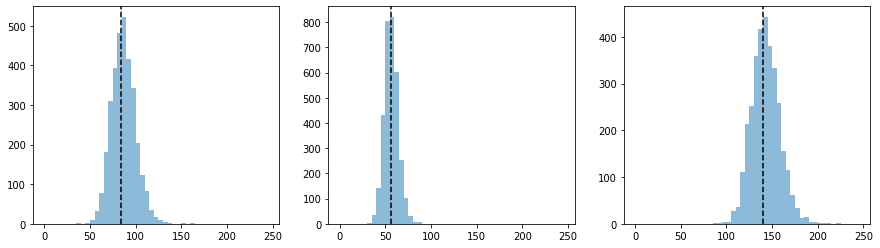

In [195]:
children = sorted([x for x in child_to_num_mat_crossovers.keys()])
num_crossovers_mat = np.array([child_to_num_mat_crossovers[x] for x in children])
num_crossovers_pat = np.array([child_to_num_pat_crossovers[x] for x in children])
famsize = np.array([child_to_famsize[x] for x in children])

bins = np.arange(0, 250, 5)

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.hist(np.clip(num_crossovers_mat[famsize==4], 0, bins[-2]), bins=bins, alpha=0.5)
plt.hist(np.clip(num_crossovers_mat[famsize==5], 0, bins[-2]), bins=bins, alpha=0.5)
plt.hist(np.clip(num_crossovers_mat[famsize==6], 0, bins[-2]), bins=bins, alpha=0.5)
plt.hist(np.clip(num_crossovers_mat[famsize>6], 0, bins[-2]), bins=bins, alpha=0.5)
plt.axvline(42*2, color='black', linestyle='--')

plt.subplot(1, 3, 2)
plt.hist(np.clip(num_crossovers_pat[famsize==4], 0, bins[-2]), bins=bins, alpha=0.5)
plt.hist(np.clip(num_crossovers_pat[famsize==5], 0, bins[-2]), bins=bins, alpha=0.5)
plt.hist(np.clip(num_crossovers_pat[famsize==6], 0, bins[-2]), bins=bins, alpha=0.5)
plt.hist(np.clip(num_crossovers_pat[famsize>6], 0, bins[-2]), bins=bins, alpha=0.5)
plt.axvline(28*2, color='black', linestyle='--')

plt.subplot(1, 3, 3)
plt.hist(np.clip(num_crossovers_mat[famsize==4]+num_crossovers_pat[famsize==4], 0, bins[-2]), bins=bins, alpha=0.5)
plt.hist(np.clip(num_crossovers_mat[famsize==5]+num_crossovers_pat[famsize==5], 0, bins[-2]), bins=bins, alpha=0.5)
plt.hist(np.clip(num_crossovers_mat[famsize==6]+num_crossovers_pat[famsize==6], 0, bins[-2]), bins=bins, alpha=0.5)
plt.hist(np.clip(num_crossovers_mat[famsize>6]+num_crossovers_pat[famsize>6], 0, bins[-2]), bins=bins, alpha=0.5)
plt.axvline(28*2+42*2, color='black', linestyle='--')
plt.show()

In [197]:
print(np.min(num_crossovers_mat), np.min(num_crossovers_pat))

38 33


In [9]:
crossover_lens_mat, crossover_lens_pat = [], []
is_complex_mat, is_complex_pat = [], []
for child, crossovers in child_to_crossovers.items():
    for co in crossovers:
        length = co['end_pos']-co['start_pos']
        if co['is_mat']:
            crossover_lens_mat.append(length)
            is_complex_mat.append(co['is_complex'])
        if co['is_pat']:
            crossover_lens_pat.append(length)
            is_complex_pat.append(co['is_complex'])
                
crossover_lens_mat = np.array(crossover_lens_mat)
crossover_lens_pat = np.array(crossover_lens_pat)
is_complex_mat = np.array(is_complex_mat)
is_complex_pat = np.array(is_complex_pat)

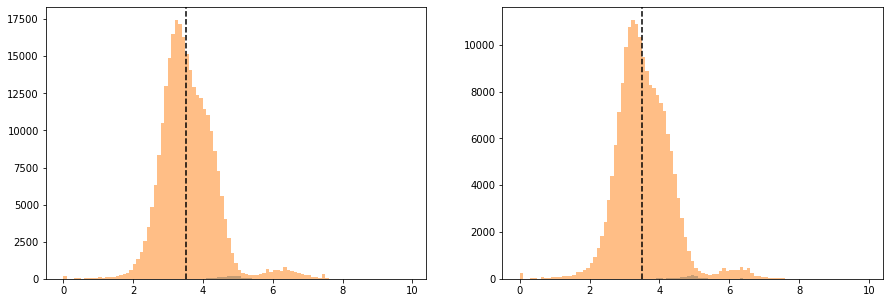

In [10]:
bins=np.arange(0, 10, 0.1)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(np.log10(crossover_lens_mat[is_complex_mat]), alpha=0.5, bins=bins)
plt.hist(np.log10(crossover_lens_mat[~is_complex_mat]), alpha=0.5, bins=bins)
plt.axvline(np.log10(np.median(crossover_lens_mat)), color='black', linestyle='--')

plt.subplot(1, 2, 2)
plt.hist(np.log10(crossover_lens_pat[is_complex_pat]), alpha=0.5, bins=bins)
plt.hist(np.log10(crossover_lens_pat[~is_complex_pat]), alpha=0.5, bins=bins)
plt.axvline(np.log10(np.median(crossover_lens_pat)), color='black', linestyle='--')

plt.show()

# Recombination hotspots

In [11]:
binsize=1000000
positions = set()
for chrom in range(1, 23):
    positions.update([(int(chrom), p) for p in np.arange(0, chrom_lengths[str(chrom)]+2*binsize, binsize)])
        
positions = sorted(positions)
chroms = np.array([c for c, p in positions])
poss = np.array([p for c, p in positions])
pos_to_index = dict([(x, i) for i, x in enumerate(positions)])


In [12]:
region_size = np.zeros((len(positions),), dtype=int)
indices = np.where(chroms[:-1]==chroms[1:])[0]
region_size[indices] = (poss[1:]-poss[:-1])[indices]

In [13]:
print(chroms)
print(poss)
print(region_size)

[ 1  1  1 ... 22 22 22]
[       0  1000000  2000000 ... 50000000 51000000 52000000]
[1000000 1000000 1000000 ... 1000000 1000000       0]


In [14]:
recomb_mat = np.zeros((len(positions),))
recomb_pat = np.zeros((len(positions),))

already_included = set()
for child, crossovers in child_to_crossovers.items():
    if child[0] not in already_included and child[1] not in already_included:
        for co in crossovers:
            if co['is_mat']:
                start_index, end_index = pos_to_index[(co['chrom'], int(np.floor(co['start_pos']/binsize)*binsize))], pos_to_index[(co['chrom'], int(np.ceil(co['end_pos']/binsize)*binsize))]+1
                for index in range(start_index, end_index):
                    overlap = 0
                    if chroms[index]==co['chrom'] and chroms[index+1]==co['chrom']:
                        overlap = min(poss[index+1], co['end_pos'])-max(poss[index], co['start_pos'])
                    if overlap>0:
                        recomb_mat[index] += overlap/(co['end_pos']-co['start_pos'])
            if co['is_pat']:
                start_index, end_index = pos_to_index[(co['chrom'], int(np.floor(co['start_pos']/binsize)*binsize))], pos_to_index[(co['chrom'], int(np.ceil(co['end_pos']/binsize)*binsize))]+1
                for index in range(start_index, end_index):
                    overlap = 0
                    if chroms[index]==co['chrom'] and chroms[index+1]==co['chrom']:
                        overlap = min(poss[index+1], co['end_pos'])-max(poss[index], co['start_pos'])
                    if overlap>0:
                        recomb_pat[index] += overlap/(co['end_pos']-co['start_pos'])
        already_included.add(child[0])
        already_included.add(child[1])

recomb_mat = recomb_mat/len(already_included)
recomb_pat = recomb_pat/len(already_included)

recomb_mat_clipped = np.clip(recomb_mat, 3/len(already_included), None)
recomb_pat_clipped = np.clip(recomb_pat, 3/len(already_included), None) 


In [15]:
print(len(already_included))

6492


In [16]:
recomb_mat_kong = np.zeros((len(positions),))
recomb_pat_kong = np.zeros((len(positions),))

crossover_len_mat_kong, crossover_len_pat_kong = [], []
with open('../data/DECODE/DECODE_Recombination_Events_Maternal_01OCT2013_b%s.bed' % assembly, 'r') as f:
    next(f) # skip header
    for line in f:
        pieces = line.strip().split(':')
        chrom = pieces[0]
        start_pos, end_pos = [int(x) for x in pieces[1].split('-')]
        if chrom != 'chrX':
            chrom = int(chrom[3:])
            start_index, end_index = pos_to_index[(chrom, int(np.floor(start_pos/binsize)*binsize))], pos_to_index[(chrom, int(np.ceil(end_pos/binsize)*binsize))]+1
            for index in range(start_index, end_index):
                overlap = 0
                if chroms[index]==chrom and chroms[index+1]==chrom:
                    overlap = min(poss[index+1], end_pos)-max(poss[index], start_pos)
                if overlap>0:
                    recomb_mat_kong[index] += overlap/(end_pos-start_pos)
            crossover_len_mat_kong.append(end_pos-start_pos)
with open('../data/DECODE/DECODE_Recombination_Events_Paternal_01OCT2013_b%s.bed' % assembly, 'r') as f:
    next(f) # skip header
    for line in f:
        pieces = line.strip().split(':')
        chrom = pieces[0]
        start_pos, end_pos = [int(x) for x in pieces[1].split('-')]
        if chrom != 'chrX':
            chrom = int(chrom[3:])
            start_index, end_index = pos_to_index[(chrom, int(np.floor(start_pos/binsize)*binsize))], pos_to_index[(chrom, int(np.ceil(end_pos/binsize)*binsize))]+1
            for index in range(start_index, end_index):
                overlap = 0
                if chroms[index]==chrom and chroms[index+1]==chrom:
                    overlap = min(poss[index+1], end_pos)-max(poss[index], start_pos)
                if overlap>0:
                    recomb_pat_kong[index] += overlap/(end_pos-start_pos)
            crossover_len_pat_kong.append(end_pos-start_pos)
                    
recomb_mat_kong = recomb_mat_kong/41745 # from paper - the number of meioses
recomb_pat_kong = recomb_pat_kong/30184
 
recomb_mat_kong_clipped = np.clip(recomb_mat_kong, 3/41745, None) # from paper - the number of meioses
recomb_pat_kong_clipped = np.clip(recomb_pat_kong, 3/30184, None)
                          

KeyboardInterrupt: 

In [ ]:
bins=np.arange(0, 10, 0.1)

plt.figure(figsize=(7, 5))
plt.rcParams.update({'font.size': 16})

plt.hist(np.log10(np.hstack((crossover_lens_mat, crossover_lens_pat))), 
                  alpha=0.5, bins=bins, density=True, label='ihart+ssc+mssng')
plt.hist(np.log10(np.hstack((crossover_len_mat_kong, crossover_len_pat_kong))), 
                            alpha=0.5, bins=bins, density=True, label='Kong et al')
plt.legend()
plt.xticks(np.arange(0, 10, 2), ['1' if x==0 else '$10^{%d}$' % x for x in range(0, 10, 2)])
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
plt.xlabel('Crossover Resolution')

plt.show()

In [8]:
chr_lens = [chrom_lengths[str(x)] for x in range(1, 23)]
cum_chr_lengths = np.array([0, 0] + np.cumsum(chr_lens).tolist())
#xs = cum_chr_lengths[chroms] + poss

In [ ]:
plt.figure(figsize=(15, 5))
plt.scatter(xs, np.log10(recomb_mat_clipped), alpha=0.5, marker='.')
plt.scatter(xs, np.log10(recomb_pat_clipped), alpha=0.5, marker='.')
plt.scatter(xs, np.log10(recomb_mat_kong_clipped), alpha=0.5, marker='.')
plt.scatter(xs, np.log10(recomb_pat_kong_clipped), alpha=0.5, marker='.')
plt.xticks(cum_chr_lengths[1:], [str(x) for x in range(1, 23)])
plt.show()

In [ ]:
chrom = 22
plt.figure(figsize=(15, 5))
p = plt.plot(poss[(chroms==chrom)], np.log10(recomb_mat_clipped[(chroms==chrom)]), label='ihart+ssc+mssng mat')
q = plt.plot(poss[(chroms==chrom)], np.log10(recomb_pat_clipped[(chroms==chrom)]), label='ihart+ssc+mssng pat')
plt.plot(poss[(chroms==chrom)], np.log10(recomb_mat_kong_clipped[(chroms==chrom)]), color='black', linestyle='--', label='Kong et al mat', alpha=0.5)#plt.plot(poss[(chroms==chrom)], np.log10(recomb_pat_kong[(chroms==chrom)]), color='black', linestyle='--', label='Kong pat', alpha=0.5)
plt.plot(poss[(chroms==chrom)], np.log10(recomb_pat_kong_clipped[(chroms==chrom)]), color='black', linestyle='--', label='Kong et al pat', alpha=0.5)#plt.plot(poss[(chroms==chrom)], np.log10(recomb_pat_kong[(chroms==chrom)]), color='black', linestyle='--', label='Kong pat', alpha=0.5)
plt.xticks([x[1] for x in cyto if x[0]=='chr%d' % chrom], [str(chrom) + x[3] for x in cyto if x[0]=='chr%d' % chrom], rotation=90)
plt.legend()

#plt.xlim([23443586, 23528597])
plt.title('Recombination Rate Chrom %d' % chrom)
plt.show()

In [ ]:
chrom, start_pos, end_pos = 12, 0, 1000000

recomb_mat_detailed = np.zeros((end_pos-start_pos,))
recomb_pat_detailed = np.zeros((end_pos-start_pos,))

for child, crossovers in child_to_crossovers.items():
    for co in crossovers:
        if (co['chrom'] == chrom) and (min(end_pos, co['end_pos'])-max(start_pos, co['start_pos'])>0):
            if co['is_mat']:
                start_index, end_index = np.clip(co['start_pos']-start_pos, 0, end_pos-start_pos), np.clip(co['end_pos']-start_pos, 0, end_pos-start_pos)
                recomb_mat_detailed[start_index:end_index] += (1/(co['end_pos']-co['start_pos']))
            if co['is_pat']:
                start_index, end_index = np.clip(co['start_pos']-start_pos, 0, end_pos-start_pos), np.clip(co['end_pos']-start_pos, 0, end_pos-start_pos)
                recomb_pat_detailed[start_index:end_index] += (1/(co['end_pos']-co['start_pos']))

recomb_mat_detailed = recomb_mat_detailed/len(already_included)
recomb_pat_detailed = recomb_pat_detailed/len(already_included)

#recomb_mat_detailed = np.clip(recomb_mat_detailed/len(already_included), 3/len(already_included), None)
#recomb_pat_detailed = np.clip(recomb_pat_detailed/len(already_included), 3/len(already_included), None) 


In [ ]:
recomb_mat_kong_detailed = np.zeros((end_pos-start_pos,))
recomb_pat_kong_detailed = np.zeros((end_pos-start_pos,))

with open('../data/DECODE/DECODE_Recombination_Events_Maternal_01OCT2013_b%s.bed' % assembly, 'r') as f:
    next(f) # skip header
    for line in f:
        pieces = line.strip().split(':')
        co_chrom = pieces[0]
        co_start_pos, co_end_pos = [int(x) for x in pieces[1].split('-')]
        if co_chrom != 'chrX':
            co_chrom = int(co_chrom[3:])
            if (co_chrom == chrom) and (min(end_pos, co_end_pos)-max(start_pos, co_start_pos)>0):
                start_index, end_index = np.clip(co_start_pos-start_pos, 0, end_pos-start_pos), np.clip(co_end_pos-start_pos, 0, end_pos-start_pos)
                recomb_mat_kong_detailed[start_index:end_index] += (1/(co_end_pos-co_start_pos))
                
with open('../data/DECODE/DECODE_Recombination_Events_Paternal_01OCT2013_b%s.bed' % assembly, 'r') as f:
    next(f) # skip header
    for line in f:
        pieces = line.strip().split(':')
        co_chrom = pieces[0]
        co_start_pos, co_end_pos = [int(x) for x in pieces[1].split('-')]
        if co_chrom != 'chrX':
            co_chrom = int(co_chrom[3:])
            if (co_chrom == chrom) and (min(end_pos, co_end_pos)-max(start_pos, co_start_pos)>0):
                start_index, end_index = np.clip(co_start_pos-start_pos, 0, end_pos-start_pos), np.clip(co_end_pos-start_pos, 0, end_pos-start_pos)
                recomb_pat_kong_detailed[start_index:end_index] += (1/(co_end_pos-co_start_pos))
                
recomb_mat_kong_detailed = recomb_mat_kong_detailed/41745
recomb_pat_kong_detailed = recomb_pat_kong_detailed/30184


In [ ]:
smooth_factor = 10000

plt.figure(figsize=(15, 5))
p = plt.plot(np.arange(start_pos, end_pos), np.log10(recomb_mat_detailed), label='ihart+ssc+mssng mat', alpha=0.2)
plt.plot(np.arange(start_pos+(smooth_factor/2), end_pos-(smooth_factor/2)+1), np.convolve(np.log10(recomb_mat_detailed), np.ones((smooth_factor,)), mode='valid')/smooth_factor, 
            color=p[0].get_color())
q = plt.plot(np.arange(start_pos, end_pos), np.log10(recomb_pat_detailed), label='ihart+ssc+mssng pat', alpha=0.2)
plt.plot(np.arange(start_pos+(smooth_factor/2), end_pos-(smooth_factor/2)+1), np.convolve(np.log10(recomb_pat_detailed), np.ones((smooth_factor,)), mode='valid')/smooth_factor, 
            color=q[0].get_color())

plt.axhline(np.log10(np.sum(recomb_mat_detailed)), color=p[0].get_color(), alpha=0.5)
plt.axhline(np.log10(np.sum(recomb_pat_detailed)), color=q[0].get_color(), alpha=0.5)

p = plt.plot(np.arange(start_pos, end_pos), np.log10(recomb_mat_kong_detailed), label='Kong mat', alpha=0.2)
plt.plot(np.arange(start_pos+(smooth_factor/2), end_pos-(smooth_factor/2)+1), np.convolve(np.log10(recomb_mat_kong_detailed), np.ones((smooth_factor,)), mode='valid')/smooth_factor, 
            color=p[0].get_color())
q = plt.plot(np.arange(start_pos, end_pos), np.log10(recomb_pat_kong_detailed), label='Kong pat', alpha=0.2)
plt.plot(np.arange(start_pos+(smooth_factor/2), end_pos-(smooth_factor/2)+1), np.convolve(np.log10(recomb_pat_kong_detailed), np.ones((smooth_factor,)), mode='valid')/smooth_factor, 
            color=q[0].get_color())

plt.axhline(np.log10(np.sum(recomb_mat_kong_detailed)), color=p[0].get_color(), alpha=0.5)
plt.axhline(np.log10(np.sum(recomb_pat_kong_detailed)), color=q[0].get_color(), alpha=0.5)

#plt.xticks([x[1] for x in cyto if x[0]=='chr%d' % chrom], [x[3] for x in cyto if x[0]=='chr%d' % chrom], rotation=90)
plt.legend()


#plt.xlim([70000, 90000])
plt.title('Recombination Rate')
plt.show()

In [ ]:
plt.figure(figsize=(7, 5))
plt.scatter(np.log10(recomb_mat_clipped), np.log10(recomb_mat_kong_clipped), alpha=0.5, marker='.', label='mat')
plt.scatter(np.log10(recomb_pat_clipped), np.log10(recomb_pat_kong_clipped), alpha=0.5, marker='.', label='pat')

indices = ~np.isclose(recomb_mat_clipped, np.min(recomb_mat_clipped)) & ~np.isclose(recomb_mat_kong_clipped, np.min(recomb_mat_kong_clipped))
plt.scatter(np.log10(recomb_mat_clipped[~indices]), np.log10(recomb_mat_kong_clipped[~indices]), marker='.', color='red')
print(stats.pearsonr(recomb_mat_clipped[indices], recomb_mat_kong_clipped[indices]))
indices = ~np.isclose(recomb_pat_clipped, np.min(recomb_pat_clipped)) & ~np.isclose(recomb_pat_kong_clipped, np.min(recomb_pat_kong_clipped))
plt.scatter(np.log10(recomb_pat_clipped[~indices]), np.log10(recomb_pat_kong_clipped[~indices]), marker='.', color='red')
print(stats.pearsonr(recomb_pat_clipped[indices], recomb_pat_kong_clipped[indices]))

plt.xlabel('Our Recombination Estimate')
plt.ylabel('Kong et al Recombination Estimate')
plt.xticks(np.arange(-4, 0), ['$10^{%d}$' % x for x in np.arange(-4, 0)])
plt.yticks(np.arange(-4, 0), ['$10^{%d}$' % x for x in np.arange(-4, 0)])
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.legend()
plt.title('Recombination rate comparison 10KB')
plt.show()

In [ ]:
plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 2, 1)
plt.scatter(np.log10(recomb_mat_clipped), np.log10(recomb_pat_clipped), alpha=0.1, marker='.')

#indices = ~np.isclose(recomb_mat_kong_clipped, np.min(recomb_mat_kong_clipped)) & ~np.isclose(recomb_pat_kong_clipped, np.min(recomb_pat_kong_clipped))
#plt.scatter(np.log10(recomb_mat_clipped[~indices]), np.log10(recomb_pat_clipped[~indices]), marker='.', alpha=0.2)
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')

indices = ~np.isclose(recomb_mat_clipped, np.min(recomb_mat_clipped)) & ~np.isclose(recomb_pat_clipped, np.min(recomb_pat_clipped))
plt.scatter(np.log10(recomb_mat_clipped[~indices]), np.log10(recomb_pat_clipped[~indices]), marker='.', color='red')
print(stats.pearsonr(recomb_mat_clipped[indices], recomb_pat_clipped[indices]))

plt.title('Our Recombination Estimates')
plt.xlabel('Maternal')
plt.ylabel('Paternal')

plt.subplot(1, 2, 2, sharex=ax, sharey=ax)
plt.scatter(np.log10(recomb_mat_kong_clipped), np.log10(recomb_pat_kong_clipped), alpha=0.1, marker='.')
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')

indices = ~np.isclose(recomb_mat_kong_clipped, np.min(recomb_mat_kong_clipped)) & ~np.isclose(recomb_pat_kong_clipped, np.min(recomb_pat_kong_clipped))
plt.scatter(np.log10(recomb_mat_kong_clipped[~indices]), np.log10(recomb_pat_kong_clipped[~indices]), marker='.', color='red')
print(stats.pearsonr(recomb_mat_kong_clipped[indices], recomb_pat_kong_clipped[indices]))

plt.title('Kong et al Recombination Estimates')
plt.xlabel('Maternal')
plt.ylabel('Paternal')

plt.show()

In [ ]:
plt.figure(figsize=(15, 5))

ax = plt.subplot(1, 2, 1)
plt.hist(np.log10(recomb_mat[recomb_mat != 0]), alpha=0.5, bins=np.arange(-6, 0, 0.1), density=True)
indices = ~np.isclose(recomb_mat[recomb_mat != 0], np.min(recomb_mat[recomb_mat != 0]))
params = stats.gamma.fit(-np.log10(recomb_mat[recomb_mat != 0][indices]))
print('mat params', params)
plt.plot(np.arange(0, -6, -0.1), stats.gamma.pdf(np.arange(0, 6, 0.1), *params), color='black', linestyle='--')

#plt.hist(np.log10(recomb_mat_kong), alpha=0.5, bins=np.arange(-6, 0, 0.1), density=True)
#indices = ~np.isclose(recomb_mat_kong, np.min(recomb_mat_kong))
#params = stats.gamma.fit(-np.log10(recomb_mat_kong[indices]))
#print(params)
#plt.plot(np.arange(0, -6, -0.1), stats.gamma.pdf(np.arange(0, 6, 0.1), *stats.gamma.fit(-np.log10(recomb_mat_kong[indices]))), color='black', linestyle='--')
#
plt.xticks(np.arange(-6, 1), ['1' if x==0 else '$10^{%d}$' % x for x in np.arange(-6, 1)])

plt.subplot(1, 2, 2, sharex=ax, sharey=ax)
plt.hist(np.log10(recomb_pat[recomb_pat!=0]), alpha=0.5, bins=np.arange(-6, 0, 0.1), density=True)
indices = ~np.isclose(recomb_pat, np.min(recomb_pat))
params = stats.gamma.fit(-np.log10(recomb_pat[indices]))
print('pat params', params)
plt.plot(np.arange(0, -6, -0.1), stats.gamma.pdf(np.arange(0, 6, 0.1), *params), color='black', linestyle='--')

#plt.hist(np.log10(recomb_pat_kong[recomb_pat_kong!=0]), alpha=0.5, bins=np.arange(-6, 0, 0.1), density=True)
#indices = ~np.isclose(recomb_pat_kong, np.min(recomb_pat_kong))
#params = stats.gamma.fit(-np.log10(recomb_pat_kong[indices]))
#print(params)
#plt.plot(np.arange(0, -6, -0.1), stats.gamma.pdf(np.arange(0, 6, 0.1), *stats.gamma.fit(-np.log10(recomb_pat_kong[indices]))), color='black', linestyle='--')

plt.xticks(np.arange(-6, 1), ['1' if x==0 else '$10^{%d}$' % x for x in np.arange(-6, 1)])
plt.show()

In [ ]:
ordered_recomb_mat = np.flip(recomb_mat[np.argsort(recomb_mat)]*len(already_included))
ordered_recomb_pat = np.flip(recomb_pat[np.argsort(recomb_pat)]*len(already_included))

num_mat_recomb = np.sum(recomb_mat*len(already_included))
plt.plot(np.arange(0, 1, 1/len(ordered_recomb_mat))[:len(ordered_recomb_mat)], 
         np.cumsum(ordered_recomb_mat)/num_mat_recomb)

num_pat_recomb = np.sum(recomb_pat*len(already_included))
plt.plot(np.arange(0, 1, 1/len(ordered_recomb_pat))[:len(ordered_recomb_pat)],
         np.cumsum(ordered_recomb_pat)/num_pat_recomb)
plt.xlabel('Fraction of $10^{%d}$ intervals' % np.log10(binsize))
plt.ylabel('Fraction of recombinations')
plt.show()

# Learning hotspots and coldspots

In [9]:
from sklearn.linear_model import LogisticRegression
import scipy.sparse as sparse
import cvxpy as cp


In [198]:
all_positions_mat = set()
num_crossovers_mat = 0
all_positions_pat = set()
num_crossovers_pat = 0
for child, crossovers in child_to_crossovers.items():
    for co in crossovers:
        if co['is_mat']:
            all_positions_mat.add((co['chrom'], co['start_pos']))
            all_positions_mat.add((co['chrom'], co['end_pos']))
            num_crossovers_mat += 1
        if co['is_pat']:
            all_positions_pat.add((co['chrom'], co['start_pos']))
            all_positions_pat.add((co['chrom'], co['end_pos']))
            num_crossovers_pat += 1

for chrom in range(1, 23):
    all_positions_mat.update([(chrom, p) for p in np.arange(0, chrom_lengths[str(chrom)]+1000000, 1000000)])
    all_positions_pat.update([(chrom, p) for p in np.arange(0, chrom_lengths[str(chrom)]+1000000, 1000000)])
        
all_positions = sorted(all_positions_mat | all_positions_pat)
pos_to_index = dict([(x, i) for i, x in enumerate(all_positions)])
print('num_crossovers', num_crossovers_mat+num_crossovers_pat, 'positions', len(all_positions))

all_positions_mat = sorted(all_positions_mat)
pos_to_index_mat = dict([(x, i) for i, x in enumerate(all_positions_mat)])
print('num_crossovers', num_crossovers_mat, 'positions', len(all_positions_mat))

all_positions_pat = sorted(all_positions_pat)
pos_to_index_pat = dict([(x, i) for i, x in enumerate(all_positions_pat)])
print('num_crossovers', num_crossovers_pat, 'positions', len(all_positions_pat))



num_crossovers 461869 positions 594565
num_crossovers 279884 positions 398618
num_crossovers 181985 positions 264547


In [199]:
lengths_mat = np.array([0 if all_positions_mat[i][0] != all_positions_mat[i+1][0] else all_positions_mat[i+1][1]-all_positions_mat[i][1] for i in range(len(all_positions_mat)-1)])
lengths_pat = np.array([0 if all_positions_pat[i][0] != all_positions_pat[i+1][0] else all_positions_pat[i+1][1]-all_positions_pat[i][1] for i in range(len(all_positions_pat)-1)])
lengths = np.array([0 if all_positions[i][0] != all_positions[i+1][0] else all_positions[i+1][1]-all_positions[i][1] for i in range(len(all_positions)-1)])
    
           

In [200]:
all_positions_mat, pos_to_index_mat, lengths_mat = all_positions, pos_to_index, lengths
all_positions_pat, pos_to_index_pat, lengths_pat = all_positions, pos_to_index, lengths

In [201]:
X_mat, X_pat = [], []
n_mat, n_pat = len(all_positions_mat)-1, len(all_positions_pat)-1
neg_count_mat = np.zeros((n_mat, 1), dtype=int)
neg_count_pat = np.zeros((n_pat, 1), dtype=int)

for child, crossovers in child_to_crossovers.items():
    mat_crossovers = [co for co in crossovers if co['is_mat']]
    data, row_ind, col_ind = [], [], []
    row_i = 0
    for co in mat_crossovers:
        start_index, end_index = pos_to_index_mat[(co['chrom'], co['start_pos'])], pos_to_index_mat[(co['chrom'], co['end_pos'])]
        data.extend([1,]*(end_index-start_index))
        row_ind.extend([row_i,]*(end_index-start_index))
        col_ind.extend(range(start_index, end_index))
        row_i += 1
    X_mat.append(sparse.csr_matrix((data, (row_ind, col_ind)), shape=(len(mat_crossovers), n_mat)))
    neg_count_mat += 2-X_mat[-1].sum(axis=0).T
        
    pat_crossovers = [co for co in crossovers if co['is_pat']]
    data, row_ind, col_ind = [], [], []
    row_i = 0
    for co in pat_crossovers:
        start_index, end_index = pos_to_index_pat[(co['chrom'], co['start_pos'])], pos_to_index_pat[(co['chrom'], co['end_pos'])]
        data.extend([1,]*(end_index-start_index))
        row_ind.extend([row_i,]*(end_index-start_index))
        col_ind.extend(range(start_index, end_index))
        row_i += 1
    X_pat.append(sparse.csr_matrix((data, (row_ind, col_ind)), shape=(len(pat_crossovers), n_pat)))
    neg_count_pat += 2-X_pat[-1].sum(axis=0).T
        
X_mat = sparse.vstack(X_mat) 
X_pat = sparse.vstack(X_pat)

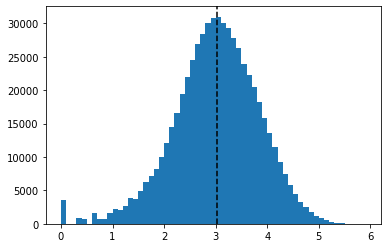

In [202]:
plt.hist(np.log10(lengths[lengths != 0]), bins=np.arange(0, 6, 0.1))
plt.axvline(np.median(np.log10(lengths[lengths != 0])), color='black', linestyle='--')
plt.show()

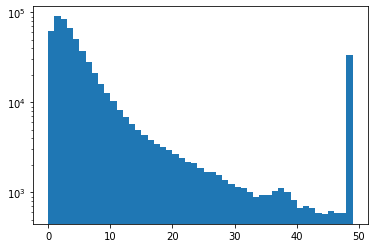

In [203]:
plt.hist(np.clip(X_mat.sum(axis=0).A.flatten(), 0, 49), bins=np.arange(0, 50), log=True)
plt.show()

In [204]:
import gurobipy
import cvxpy as cp
import mosek

def estimate_recombination_rates(X, neg_count, lengths, positions, n):
    print('Estimating...', X.shape, neg_count.shape)
    lamb = 1000

    # cvxpy
    num_crossovers = X.sum(axis=0).A.flatten()
    
    p = cp.Variable(X.shape[1])
    
    expr = cp.sum(cp.log(X@p))/n #+ ((neg_count.T)@cp.log(1-p))/n
    
    # minimize difference within chromosomes
    current_chrom = positions[0][0]
    current_chrom_start = 0
    for i in range(1, len(positions)):
        if positions[i][0] != current_chrom:
            expr -= cp.tv(lamb*p[current_chrom_start:i]/lengths[current_chrom_start:i])
            current_chrom, current_chrom_start = positions[i][0], i
    expr -= cp.tv(lamb*p[current_chrom_start:i]/lengths[current_chrom_start:i])
            
    prob = cp.Problem(cp.Maximize(expr), [p >= 0, p <= 1, cp.sum(p)==1])
    #result = prob.solve(solver='MOSEK', mosek_params={'MSK_IPAR_INTPNT_MAX_ITERATIONS': 300}, verbose=True)
    result = prob.solve(solver='GUROBI', max_iters=200, verbose=True)
    #result = prob.solve(solver='ECOS', max_iters=200, verbose=True)
    print(prob.status)

    ps = np.clip([v for v in p.value], 0, 1)

    if prob.status != 'optimal' and prob.status != 'optimal_inaccurate':
        raise Error('Parameters not fully estimated.')
    return ps

#ps_mat = estimate_recombination_rates(X_mat, y_mat, lengths_mat, len(already_included))
#ps_pat = estimate_recombination_rates(X_pat, y_pat, lengths_pat, len(already_included))
ps_mat = estimate_recombination_rates(X_mat, neg_count_mat, lengths_mat, all_positions_mat, n_mat)
ps_pat = estimate_recombination_rates(X_pat, neg_count_pat, lengths_pat, all_positions_pat, n_pat)


Estimating... (279884, 594564) (594564, 1)


SolverError: Either candidate conic solvers (['GUROBI']) do not support the cones output by the problem (ExpCone, NonNeg, Zero), or there are not enough constraints in the problem.

In [160]:
print(np.sum(ps_mat))
print(ps_mat)

1.000000000072553
[3.16271117e-10 3.02842467e-10 3.23744205e-10 ... 8.61686236e-07
 5.75557664e-10 3.18557227e-10]


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


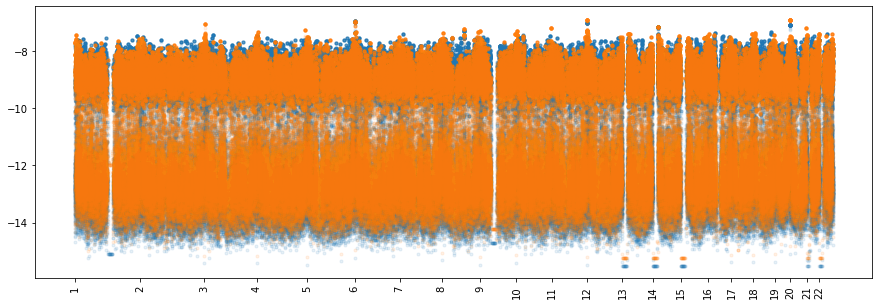

In [161]:
plt.figure(figsize=(15, 5))
plt.scatter([cum_chr_lengths[c]+p for c, p in all_positions_mat[:-1]], np.log10(ps_mat) - np.log10(lengths_mat), marker='.', alpha=0.1)
plt.scatter([cum_chr_lengths[c]+p for c, p in all_positions_pat[:-1]], np.log10(ps_pat) - np.log10(lengths_pat), marker='.', alpha=0.1)
#plt.plot(xs, np.log10(recomb_mat_clipped), label='ihart+ssc+mssng mat', alpha=0.1)
plt.xticks(cum_chr_lengths[1:-1], range(1, 23), rotation=90)
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in subtract
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in greater


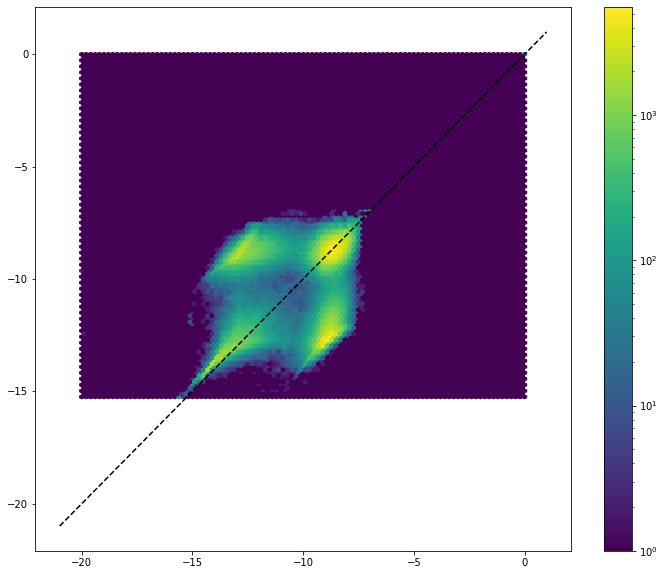

In [162]:
plt.figure(figsize=(12, 10))

#indices = (ps_mat>0) | (ps_pat>0)
#plt.hexbin(np.clip(np.log10(ps_mat), -10, 0), 
#            np.clip(np.log10(ps_pat), -10, 0),
#          gridsize=100, bins='log')#, marker='.', alpha=0.1)

plt.hexbin(np.clip(np.log10(ps_mat) - np.log10(lengths), -20, 0), 
            np.clip(np.log10(ps_pat) - np.log10(lengths), -20, 0),
          gridsize=100, bins='log')#, marker='.', alpha=0.1)
plt.colorbar()

indices = np.abs((np.log10(ps_mat) - np.log10(lengths)) - (np.log10(ps_pat) - np.log10(lengths)))>2
#plt.scatter(np.clip(np.log10(ps_mat) - np.log10(lengths), -15, 0)[indices], 
#            np.clip(np.log10(ps_pat) - np.log10(lengths), -15, 0)[indices], marker='.')
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
#plt.xlim([-7, None])
#plt.ylim([-7, None])
plt.show()

In [191]:
print(np.sum((np.log10(ps_mat) - np.log10(lengths) > -10) & (np.log10(ps_pat) - np.log10(lengths) > -10)))
print(np.sum((np.log10(ps_mat) - np.log10(lengths) > -10) & (np.log10(ps_pat) - np.log10(lengths) < -10)))
print(np.sum((np.log10(ps_mat) - np.log10(lengths) < -10) & (np.log10(ps_pat) - np.log10(lengths) > -10)))

244008
151085
104457


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


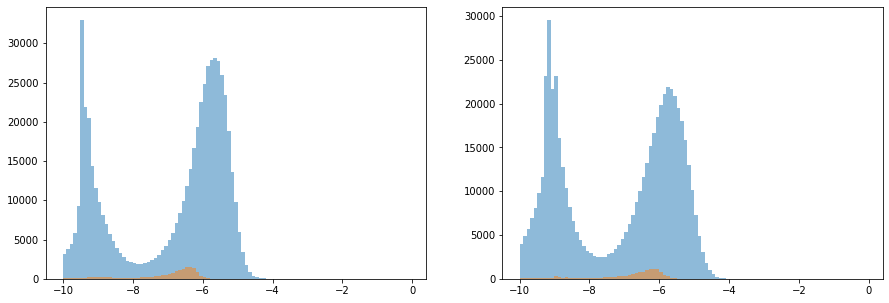

In [163]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(np.log10(ps_mat)[ps_pat > 10**-10], alpha=0.5, bins=np.arange(-10, 0, 0.1))
plt.hist(np.log10(ps_mat)[ps_pat < 10**-10], alpha=0.5, bins=np.arange(-10, 0, 0.1))

plt.subplot(1, 2, 2)
plt.hist(np.log10(ps_pat)[ps_mat > 10**-10], alpha=0.5, bins=np.arange(-10, 0, 0.1))
plt.hist(np.log10(ps_pat)[ps_mat < 10**-10], alpha=0.5, bins=np.arange(-10, 0, 0.1))
plt.show()

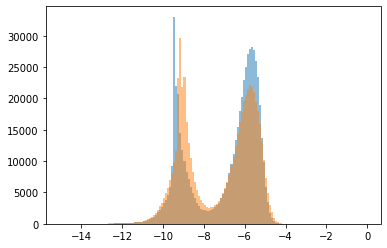

In [164]:
plt.hist(np.log10(ps_mat), bins=np.arange(-15, 0, 0.1), alpha=0.5)
plt.hist(np.log10(ps_pat), bins=np.arange(-15, 0, 0.1), alpha=0.5)
#plt.axvline(np.log10(p_baseline), color='black', linestyle='--')
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10


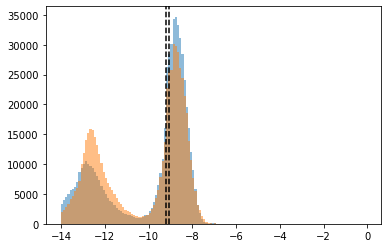

In [165]:
plt.hist(np.log10(ps_mat) - np.log10(lengths_mat), bins=np.arange(-14, 0, 0.1), alpha=0.5)
plt.hist(np.log10(ps_pat) - np.log10(lengths_pat), bins=np.arange(-14, 0, 0.1), alpha=0.5)
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10


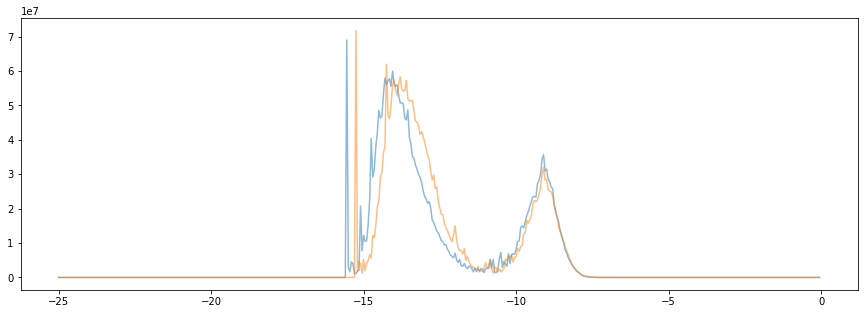

0.24978187357118115
0.2241927239348805


In [166]:
plt.figure(figsize=(15, 5))

bins = np.arange(-25, 0, 0.05)
a = np.zeros((len(bins),))
for d, l in zip(np.digitize(np.log10(ps_mat)-np.log10(lengths_mat), bins), lengths_mat):
    if d>0:
        a[d-1] += l
plt.plot(bins, a, alpha=0.5)
#print(a)

b = np.zeros((len(bins),))
for d, l in zip(np.digitize(np.log10(ps_pat)-np.log10(lengths_pat), bins), lengths_pat):
    if d>0:
        b[d-1] += l
plt.plot(bins, b, alpha=0.5)
#plt.xlim(-10, -5)
#plt.ylim(0, 10**7.5)
#print(b)

plt.show()

print(np.sum(a[np.where(bins>-10)[0]])/np.sum(lengths_mat))
print(np.sum(b[np.where(bins>-10)[0]])/np.sum(lengths_pat))


In [181]:
p_baseline = 10**-10

is_hotspot_mat = ps_mat>(lengths_mat*p_baseline)
is_coldspot_mat = ps_pat>(lengths_pat*p_baseline)

print('hotspots mat')
print(np.sum(is_hotspot_mat), np.sum(is_hotspot_mat)/ps_mat.shape[0])
print(np.sum(lengths_mat*is_hotspot_mat)/np.sum(lengths_mat))

print('coldspots mat')
print(np.sum(is_coldspot_mat), np.sum(is_coldspot_mat)/ps_mat.shape[0])
print(np.sum(lengths_mat*is_coldspot_mat)/np.sum(lengths_mat))

is_hotspot_pat = ~np.isclose(ps_pat, (lengths_pat*p_baseline)) & (ps_pat>(lengths_pat*p_baseline))
is_coldspot_pat = ~np.isclose(ps_pat, (lengths_pat*p_baseline)) & (ps_pat<(lengths_pat*p_baseline))

print('hotspots pat')
print(np.sum(is_hotspot_pat), np.sum(is_hotspot_pat)/ps_pat.shape[0])
print(np.sum(lengths_pat*is_hotspot_pat)/np.sum(lengths_pat))

print('coldspots pat')
print(np.sum(is_coldspot_pat), np.sum(is_coldspot_pat)/ps_pat.shape[0])
print(np.sum(lengths_pat*is_coldspot_pat)/np.sum(lengths_pat))

hotspots mat
395093 0.6645087829064659
0.24978187357118115
coldspots mat
348465 0.586084929460916
0.2241927239348805
hotspots pat
341073 0.5736522897450905
0.22399335781087634
coldspots pat
232314 0.3907300139261711
0.7753601839279529


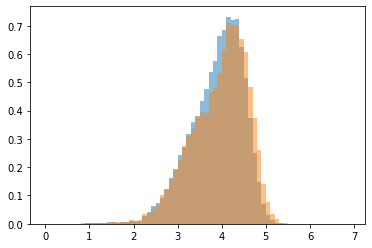

In [168]:
hotspot_start_mat = np.where(~is_hotspot_mat[:-1] & is_hotspot_mat[1:])[0]+1
hotspot_end_mat = np.where(is_hotspot_mat[:-1] & ~is_hotspot_mat[1:])[0]+1
hotspot_lengths_mat = [np.sum(lengths_mat[s:e]) for s, e in zip(hotspot_start_mat, hotspot_end_mat)]

hotspot_start_pat = np.where(~is_hotspot_pat[:-1] & is_hotspot_pat[1:])[0]+1
hotspot_end_pat = np.where(is_hotspot_pat[:-1] & ~is_hotspot_pat[1:])[0]+1
hotspot_lengths_pat = [np.sum(lengths_pat[s:e]) for s, e in zip(hotspot_start_pat, hotspot_end_pat)]

plt.hist(np.log10(hotspot_lengths_mat), bins=np.arange(0, 7, 0.1), alpha=0.5, density=True)
plt.hist(np.log10(hotspot_lengths_pat), bins=np.arange(0, 7, 0.1), alpha=0.5, density=True)
#plt.hist(np.log10(lengths), bins=np.arange(0, 7, 0.1), alpha=0.5, density=True)
plt.show()

In [169]:
print(np.median(hotspot_lengths_mat))
print(np.median(hotspot_lengths_pat))

9648.0
11557.0


In [170]:
interval_pos_mat, interval_pos_pat = [], []
interval_chrom_mat, interval_chrom_pat = [], []
data, row_ind, col_ind = [], [], []
row_i = 0
for chrom in range(1, 23):
    for p in np.arange(0, chrom_lengths[str(chrom)]+2000000, 1000000):
        if (chrom, p+1000000) in pos_to_index_mat:
            start_index, end_index = pos_to_index_mat[(chrom, p)], pos_to_index_mat[(chrom, p+1000000)]
            data.extend([1,]*(end_index-start_index))
            row_ind.extend([row_i,]*(end_index-start_index))
            col_ind.extend(range(start_index, end_index))
        row_i += 1
        interval_pos_mat.append(p)
        interval_chrom_mat.append(chrom)

test_intervals_mat = sparse.csr_matrix((data, (row_ind, col_ind)), shape=(row_i, n_mat))
interval_pos_mat = np.array(interval_pos_mat)
interval_chrom_mat = np.array(interval_chrom_mat)

data, row_ind, col_ind = [], [], []
row_i = 0
for chrom in range(1, 23):
    for p in np.arange(0, chrom_lengths[str(chrom)]+2000000, 1000000):
        if (chrom, p+1000000) in pos_to_index_pat:
            start_index, end_index = pos_to_index_pat[(chrom, p)], pos_to_index_pat[(chrom, p+1000000)]
            data.extend([1,]*(end_index-start_index))
            row_ind.extend([row_i,]*(end_index-start_index))
            col_ind.extend(range(start_index, end_index))
        row_i += 1
        interval_pos_pat.append(p)
        interval_chrom_pat.append(chrom)
            
test_intervals_pat = sparse.csr_matrix((data, (row_ind, col_ind)), shape=(row_i, n_pat))
interval_pos_pat = np.array(interval_pos_pat)
interval_chrom_pat = np.array(interval_chrom_pat)

In [171]:
pred_mat = test_intervals_mat.dot(ps_mat)
pred_pat = test_intervals_pat.dot(ps_pat)



//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10


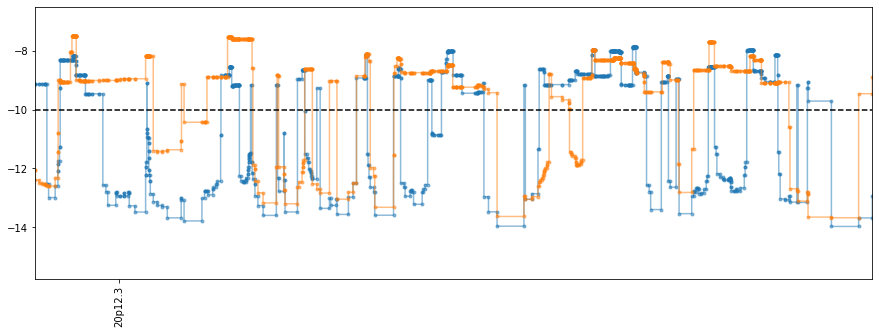

In [186]:
chrom = 20

plt.figure(figsize=(15, 5))
indices = [c==chrom for c, p in all_positions_mat[:-1]]
p = plt.plot(np.repeat([p for c, p in all_positions_mat[:-1] if c==chrom], 2)[1:], 
         np.repeat((np.log10(ps_mat)-np.log10(lengths))[indices], 2)[:-1], marker='.', alpha=0.5)
indices = [c==chrom for c, p in all_positions_pat[:-1]]
q = plt.plot(np.repeat([p for c, p in all_positions_pat[:-1] if c==chrom], 2)[1:], 
         np.repeat((np.log10(ps_pat)-np.log10(lengths))[indices], 2)[:-1], marker='.', alpha=0.5)
#plt.plot(interval_pos_mat[interval_chrom==chrom], np.log10(pred_mat[interval_chrom_mat==chrom]), label='ihart+ssc+mssng mat')
#plt.plot(interval_pos_pat[interval_chrom==chrom], np.log10(pred_pat[interval_chrom_mat==chrom]), label='ihart+ssc+mssng pat')
#plt.plot(poss[(chroms==chrom)], np.log10(recomb_mat[(chroms==chrom)]), linestyle='--')
#plt.plot(poss[(chroms==chrom)], np.log10(recomb_pat[(chroms==chrom)]), linestyle='--')
#plt.axhline(np.log10(np.median(ps_mat/lengths_mat)), color=p[0].get_color(), linestyle='--')
#plt.axhline(np.log10(np.median(ps_pat/lengths_pat)), color=q[0].get_color(), linestyle='--')
plt.axhline(-10, color='black', linestyle='--')

plt.xticks([x[1] for x in cyto if x[0]=='chr%d' % chrom], [str(chrom) + x[3] for x in cyto if x[0]=='chr%d' % chrom], rotation=90)

#plt.xlim([162790000, 162910000])
plt.xlim([5000000, 6000000])
plt.show()


In [207]:
np.save('../recombination_rate/wgs.lengths', lengths)

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in subtract
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in less
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in subtract
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in greater
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in subtract
//anaconda3/lib/python3.7/site-packages/ipykernel/__ma

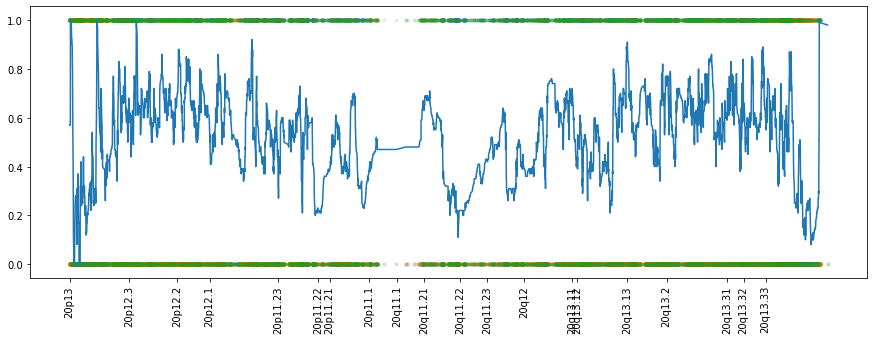

In [183]:
import pandas as pd

chrom = 20
indices = [c==chrom for c, p in all_positions_mat[:-1]]

s1 = pd.Series((np.abs((np.log10(ps_mat)-np.log10(lengths_mat))-(np.log10(ps_pat)-np.log10(lengths_pat)))<2))

plt.figure(figsize=(15, 5))
plt.plot([p for c, p in all_positions_mat[:-1] if c==chrom], s1.rolling(100).mean()[indices])
plt.scatter([p for c, p in all_positions_mat[:-1] if c==chrom], 
         ((np.abs((np.log10(ps_mat)-np.log10(lengths_mat))-(np.log10(ps_pat)-np.log10(lengths_pat)))>2) & (np.log10(ps_mat)-np.log10(lengths_mat) > np.log10(ps_pat)-np.log10(lengths_pat)))[indices], 
            marker='.', alpha=0.1)
plt.scatter([p for c, p in all_positions_mat[:-1] if c==chrom], 
         ((np.abs((np.log10(ps_mat)-np.log10(lengths_mat))-(np.log10(ps_pat)-np.log10(lengths_pat)))>2) & (np.log10(ps_mat)-np.log10(lengths_mat) < np.log10(ps_pat)-np.log10(lengths_pat)))[indices], 
            marker='.', alpha=0.1)
plt.scatter([p for c, p in all_positions_mat[:-1] if c==chrom], 
         (np.abs((np.log10(ps_mat)-np.log10(lengths_mat))-(np.log10(ps_pat)-np.log10(lengths_pat)))<2)[indices], 
            marker='.', alpha=0.1)

plt.xticks([x[1] for x in cyto if x[0]=='chr%d' % chrom], [str(chrom) + x[3] for x in cyto if x[0]=='chr%d' % chrom], rotation=90)
#plt.xlim([0, 5000000])
#plt.xlim([15000000, 30000000])
#plt.xlim([30000000, 45000000])
#plt.xlim([45000000, 60000000])

plt.show()

In [174]:
print(len(already_included))

6492


In [111]:
indices = np.where((X_mat.sum(axis=0)+X_pat.sum(axis=0)>0) & (lengths<10**4))[1]
start_interval_chrom = np.array([all_positions[i][0] for i in indices])
start_interval_pos = np.array([all_positions[i][1] for i in indices])
end_interval_chrom = np.array([all_positions[i+1][0] for i in indices])
end_interval_pos = np.array([all_positions[i+1][1] for i in indices])


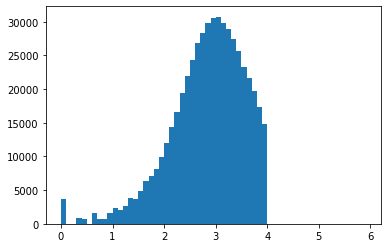

In [112]:
plt.hist(np.log10(np.clip(end_interval_pos-start_interval_pos, 1, None)),
        bins=np.arange(0, 6, 0.1))
plt.show()

In [113]:
print(np.sum(end_interval_pos-start_interval_pos)/np.sum(lengths))

0.31567676792518184


In [114]:
assert np.all([chrom_start==chrom_end for (chrom_start, pos_start), (chrom_end, pos_end) in zip(start_interval, end_interval)])



NameError: name 'start_interval' is not defined

In [570]:
import numpy as np
from scipy import sparse
import scipy.stats
import random
from collections import defaultdict
from os import listdir
import json

chrom = '22'
data_dir = '../../DATA/mssng/genotypes'

gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f], key=lambda x: int(x.split('.')[2]))
coord_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.coordinates.npy' in f], key=lambda x: int(x.split('.')[2]))
af_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.af.npy' in f], key=lambda x: int(x.split('.')[2]))
sample_file = '%s/samples.json' % data_dir


snp_positions = []
for gen_file, coord_file, af_file in zip(gen_files, coord_files, af_files):
	coords = np.load('%s/%s' % (data_dir, coord_file))
	if coords.shape[0]>0:
		snp_positions.append(coords[:, 1])

In [477]:
snp_positions = np.hstack(snp_positions)

In [478]:
variants = []
for (chrom_start, pos_start), (chrom_end, pos_end) in zip(start_interval, end_interval):
    if chrom_start == 22:
        variants.append(np.sum((snp_positions >= pos_start) & (snp_positions <= pos_end)))
        

In [479]:
variants = np.array(variants)
print(np.sum((variants>0) & (variants<100))/len(variants))

0.6068824730242053


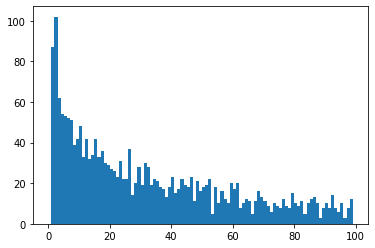

In [480]:
plt.hist(variants, bins=np.arange(0, 100))
plt.show()